<a href="https://colab.research.google.com/github/mahsaghaderan99/MLP/blob/noise-detection/mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Deep* MLP project

In [1]:
def plotter(img_list, r, w, gray, wr, hr, fig_name = None):
    '''
    Plots images' list with its' caption and saves result image if you want.

    Parameters:
        img_list (list): The list of tuples of image and its' caption.
        r (int): The number of row(s).
        w (int): The number of colunm(s).
        gray (bool): The flag for plotting images in grayscale mode.
        wr (int): The width of one figure.
        hr (int): The height of one figure.
        fig_name (str): The name of the image of the plot. if not set this parameter the plot doesn't save.
    '''
    
    plt.rcParams['figure.figsize'] = (wr, hr)
    for i in range(len(img_list)):
        plt.subplot(r, w, i + 1)
        if img_list[i][2] == 'img':
            if gray:
                plt.imshow(img_list[i][0], cmap = 'gray')
            else:
                plt.imshow(img_list[i][0])
            plt.xticks([])
            plt.yticks([])
        elif img_list[i][2] == 'hist':
            plt.bar(np.arange(len(img_list[i][0])), img_list[i][0], color = 'c')
        else:
            raise Exception("Only image or histogram. Use third parameter of tuples in img_list and set it to img or hist.")
        plt.title(img_list[i][1])
    if fig_name is not None:
        plt.savefig(fig_name + '.png')
    plt.show()

#PART5

##imports

In [2]:
import tensorflow as tf
from os import path, getcwd, chdir
import cv2
from skimage.util import random_noise
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from scipy import spatial


## load dataset

load mnist dataset 

In [3]:
path = f"{getcwd()}/mnist.npz"

In [4]:
mnist = tf.keras.datasets.mnist
(training_images, training_labels), (test_images, test_labels) = mnist.load_data(path=path)
training_images = training_images.reshape(60000,28,28)
test_images = test_images.reshape(10000,28,28)

In [5]:
m, n = training_images[0].shape[0], training_images[0].shape[1]
print('The image is ({0}*{1})'.format(m,n))

The image is (28*28)


##Preprocess Data and generate train,validation,test

Normalize images --> map value into (0,1)

In [6]:
training_images = np.array(training_images,np.float64)*(1/255)
test_images = np.array(test_images,np.float64)*(1/255)

Flatten original image --> suitable for output of the network.

In [7]:
x_train = np.reshape(training_images,(training_images.shape[0],m*n))
test_images = np.reshape(test_images,(test_images.shape[0],m*n))

In [8]:
x_test, x_val, y_test, y_val = train_test_split(test_images, test_labels, test_size=0.4, random_state=42)

In [9]:
print('train shape:',x_train.shape[0])
print('train shape:',x_val.shape[0])
print('test shape:',x_test.shape[0])

train shape: 60000
train shape: 4000
test shape: 6000


##Add noise

In [10]:
def make_noisydata(data,model,var,portion):
  noisy_data = np.empty(data.shape)
  if model == 'gaussian':
    for i in range(data.shape[0]):
      noisy_data[i] = random_noise(data[i],model,var = var)
  elif model == 's&p':
    for i in range(data.shape[0]):
      noisy_data[i] = random_noise(data[i],model,amount=portion)
  return noisy_data

In [11]:
def add_noise(model,var,portion):
  noisy_train = make_noisydata(x_train,model,var,portion)
  noisy_val = make_noisydata(x_val,model,var,portion)
  noisy_test = make_noisydata(x_test,model,var,portion)
  return noisy_train, noisy_val,noisy_test

##Generate Model


In [14]:
def generate_model(layers_number,layers_nodenum,dropout,optimizer,loss,accuracy):
  layers = []
  layers.append(tf.keras.layers.Flatten())
  for i in range(layers_number):
    layers.append(tf.keras.layers.Dense(layers_nodenum[i],activation=tf.nn.relu))
    layers.append(tf.keras.layers.Dropout(dropout[i]))
  layers.append(tf.keras.layers.Dense(m*n,activation=tf.nn.softmax))
  model = tf.keras.models.Sequential(layers)
  model.compile(optimizer=optimizer, loss=loss, metrics=[accuracy])
  model.build((None,m*n))
  model.summary()
  return model


In [23]:
def RemoveNoise(model_info,epochs):
  model = generate_model(model_info['layer_number'],model_info['layer_nodenum'],model_info['dropout_postion'],model_info['optimizer'],model_info['loss'],model_info['accuracy'])
  mcp_save = tf.keras.callbacks.ModelCheckpoint(model_info['best_model_path'], save_best_only=True, monitor='val_cosine_similarity', mode='max')
  history = model.fit(n_train,x_train,validation_data= (n_val,x_val), epochs=epochs,callbacks=[mcp_save] )

  model.load_weights(model_info['best_model_path'])
  print('best accurasy on test data is:',model.evaluate(n_test, x_test)[1])
  return model

In [20]:
def checktestsample(model,sample):
  y_pred = model.predict(np.array([n_test[sample]]))
  similarity = 1 - spatial.distance.cosine(y_pred[0], x_test[sample])
  y_pred0 = np.reshape(y_pred[0],(m,n))
  image_list = []
  image_list.append([x_test[sample].reshape((m,n)), 'Original Test Image', 'img'])
  image_list.append([n_test[sample].reshape((m,n)), 'Noisy Test Image', 'img'])
  image_list.append([y_pred0, 'Predicted Image', 'img'])
  print("cos similarity between desired and predicted is:%{0}".format(similarity))
  plotter(image_list,1,3 ,True,10,10)

In [25]:
noise_info ={
    'model': 'gaussian',
    'var': 0.1,
    'portion': 0.2
}
model_info={
    'layer_number':3,
    'layer_nodenum' : [254,128,32],
    'dropout_postion': [0,0.1,0],
    'optimizer': tf.keras.optimizers.Adam(),
    'loss': tf.keras.losses.CosineSimilarity(),
    'accuracy':tf.keras.metrics.CosineSimilarity(name='cosine_similarity'),
    'best_model_path':'.mdl_wts.hdf5'
}
n_train, n_val,n_test = add_noise(noise_info['model'],noise_info['var'],noise_info['portion'])
# best_model = RemoveNoise(model_info,epochs=35)
# checktestsample(best_model,30)

cos similarity between desired and predicted is:%0.9312701045133116


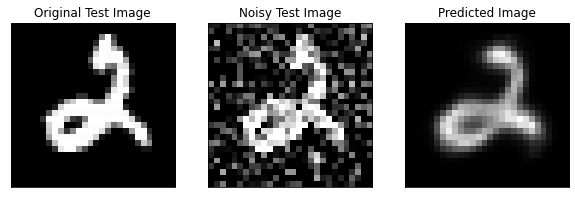

In [26]:
checktestsample(best_model,14)